#### Importing Python Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import neattext.functions as nfx
from wordcloud import WordCloud
from collections import Counter
from nrclex import NRCLex
import re
import warnings
from sklearn.feature_extraction.text import CountVectorizer

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

#### Loading the Dataset

In [2]:
data = pd.read_csv('../Dataset/depression-sampled.csv')
data.head()

,Unnamed: 0,author,created_utc,full_link,id,num_comments,score,selftext,title
0,23864,3dgyT33N666,1602609737,https://www.reddit.com/r/depression/comments/j...,jahyyq,0.0,1.0,Im fucking serious im tired as hell sad as hel...,Dear r/depression
1,227300,TallGhostXO,1576632252,https://www.reddit.com/r/depression/comments/e...,ec5gwf,3.0,1.0,I hate myself with a fucking burning passion. ...,I fucking hate myself.
2,72985,dojacool,1595740581,https://www.reddit.com/r/depression/comments/h...,hy19hz,4.0,1.0,"This is our conversation last night ,what shou...","We met a year ago, shes from russia and im fro..."
3,183306,Klutzy_Lemon,1581663644,https://www.reddit.com/r/depression/comments/f...,f3oikf,0.0,1.0,[removed],It's my birthday today.
4,294449,Arandomoboy,1569076413,https://www.reddit.com/r/depression/comments/d...,d7b8ft,1.0,6.0,Everything has changed because I kept at it an...,I'm finally so happy.


#### Initial DataFrame Construction and TimeStamp Features

In [3]:
df = pd.DataFrame()
df['Author'] = data['author']
df['UTC'] = pd.to_datetime(pd.to_numeric(data['created_utc'], errors='coerce'), unit='s')
df['Year'] = df['UTC'].dt.year.astype('Int64')
df['Month'] = df['UTC'].dt.month_name()

df.head()

,Author,UTC,Year,Month
0,3dgyT33N666,2020-10-13 17:22:17,2020,October
1,TallGhostXO,2019-12-18 01:24:12,2019,December
2,dojacool,2020-07-26 05:16:21,2020,July
3,Klutzy_Lemon,2020-02-14 07:00:44,2020,February
4,Arandomoboy,2019-09-21 14:33:33,2019,September


#### Addition of Columns in DataFrame

In [4]:
df['ID'] = data['id']
df['Comments'] = data['num_comments']
df['Score'] = data['score']
df['Text'] = data['selftext']
df['Title'] = data['title']

df.head()

,Author,UTC,Year,Month,ID,Comments,Score,Text,Title
0,3dgyT33N666,2020-10-13 17:22:17,2020,October,jahyyq,0.0,1.0,Im fucking serious im tired as hell sad as hel...,Dear r/depression
1,TallGhostXO,2019-12-18 01:24:12,2019,December,ec5gwf,3.0,1.0,I hate myself with a fucking burning passion. ...,I fucking hate myself.
2,dojacool,2020-07-26 05:16:21,2020,July,hy19hz,4.0,1.0,"This is our conversation last night ,what shou...","We met a year ago, shes from russia and im fro..."
3,Klutzy_Lemon,2020-02-14 07:00:44,2020,February,f3oikf,0.0,1.0,[removed],It's my birthday today.
4,Arandomoboy,2019-09-21 14:33:33,2019,September,d7b8ft,1.0,6.0,Everything has changed because I kept at it an...,I'm finally so happy.


#### Missing Values and Duplicates Handling

In [5]:
print("Missing values before dropping:")
print(df.isna().sum())

Missing values before dropping:
Author        0
UTC           1
Year          1
Month         1
ID            1
Comments      1
Score         1
Text        500
Title         2
dtype: int64


In [6]:
df.dropna(inplace=True)
df.shape

(29499, 9)

#### Text Cleaning Function and Application

In [7]:
def clean(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'\br\/\w+', '', text)
    text = text.replace('\n', ' ')
    text = nfx.remove_emails(text)
    text = nfx.remove_stopwords(text)
    text = nfx.remove_urls(text)
    text = nfx.remove_userhandles(text)
    text = nfx.remove_phone_numbers(text)
    text = nfx.remove_emojis(text)
    text = nfx.remove_puncts(text)
    text = nfx.remove_multiple_spaces(text)
    return text.strip()

df['Text'] = df['Text'].apply(clean)
df['Title'] = df['Title'].apply(clean)

df.head()

,Author,UTC,Year,Month,ID,Comments,Score,Text,Title
0,3dgyT33N666,2020-10-13 17:22:17,2020,October,jahyyq,0.0,1.0,im fucking im tired hell sad hell emotions con...,dear
1,TallGhostXO,2019-12-18 01:24:12,2019,December,ec5gwf,3.0,1.0,hate fucking burning passion theres person ear...,fucking hate myself
2,dojacool,2020-07-26 05:16:21,2020,July,hy19hz,4.0,1.0,conversation night what do chest crushed rock ...,met year ago shes russia im manila sad want die
3,Klutzy_Lemon,2020-02-14 07:00:44,2020,February,f3oikf,0.0,1.0,[removed],birthday today
4,Arandomoboy,2019-09-21 14:33:33,2019,September,d7b8ft,1.0,6.0,changed kept feels like control life strugglin...,im finally happy


#### Displaying the Number of Posts and Number of Unique Authors

In [8]:
print(f'Total Number of Posts : {len(df)}')
print(f"Total Number of Unique Authors : {df['Author'].nunique()}")
print(f"Total number of unique IDs : {df['ID'].nunique()}")

Total Number of Posts : 29499
Total Number of Unique Authors : 24478
Total number of unique IDs : 29499


#### Post Word Count

In [9]:
df['Word_Count'] = df['Text'].apply(lambda x : len(str(x).split()))
avg_word_count = df['Word_Count'].mean()

In [10]:
print(f'Average Post Length : {avg_word_count:.1f} words')
print(f"Average Score : {df['Score'].mean():.1f}")
print(f"Average Comments : {df['Comments'].mean():.1f}")

Average Post Length : 67.5 words
Average Score : 3.6
Average Comments : 3.2


#### Univariate Analysis - Distributions

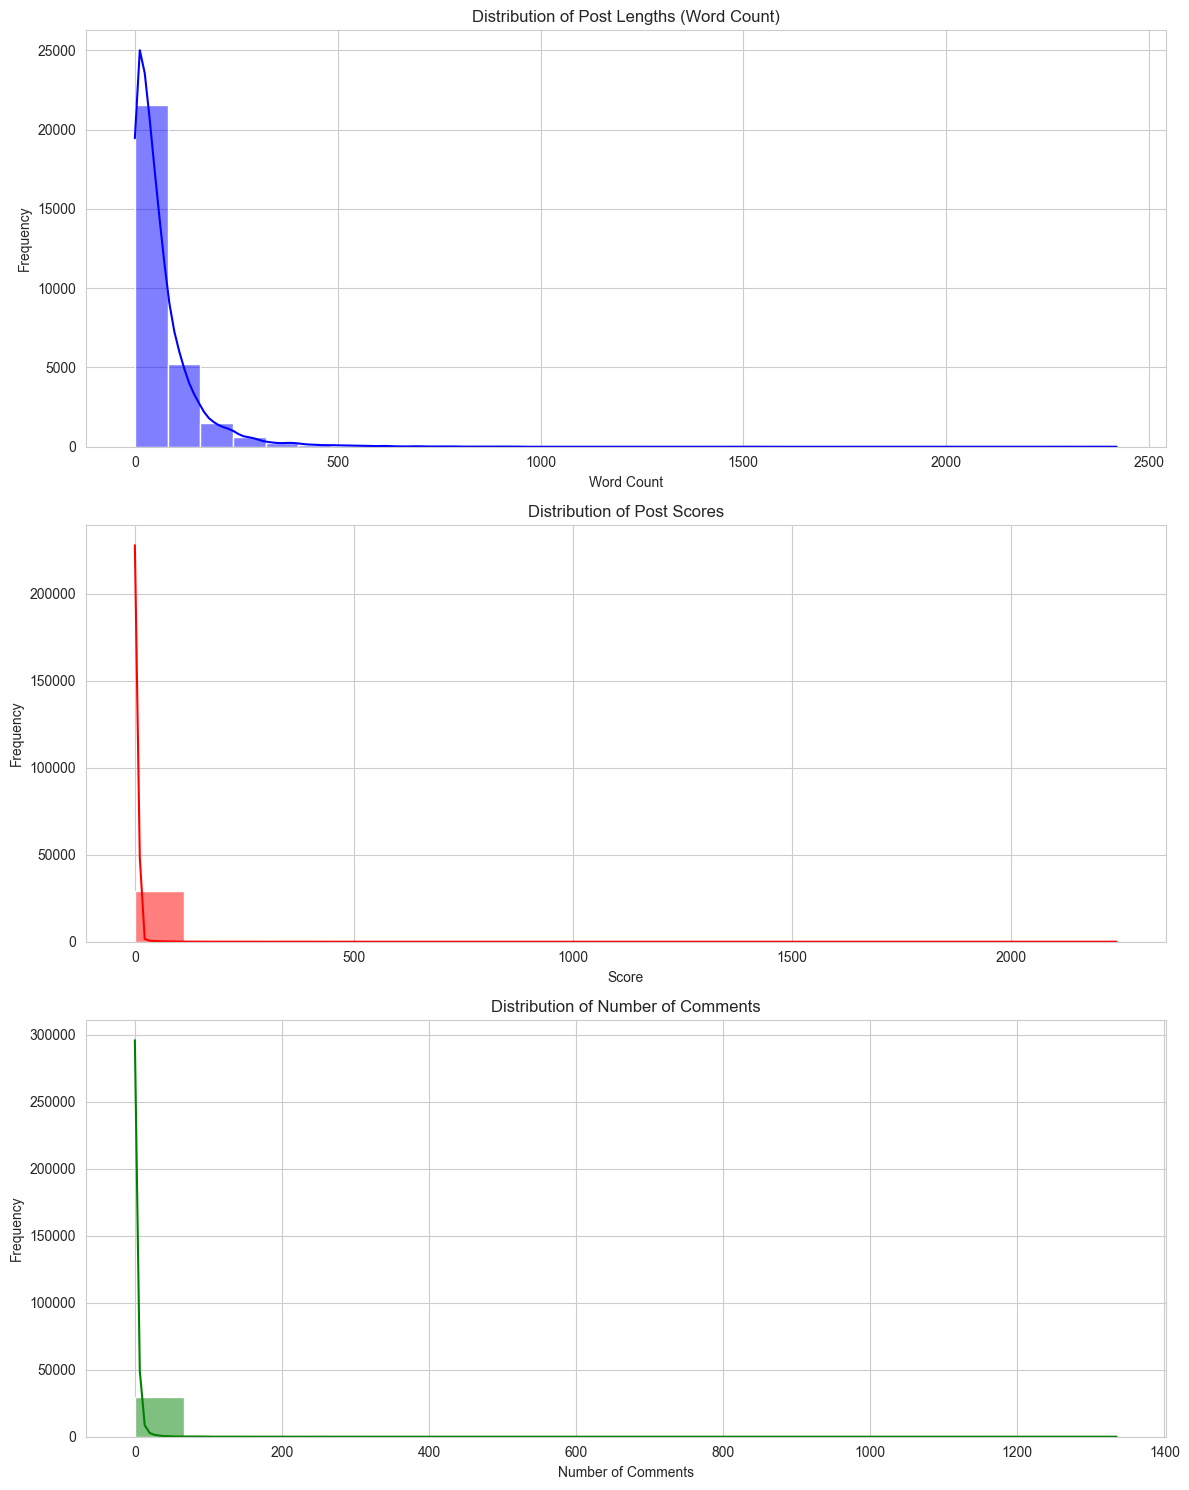

In [11]:
plt.figure(figsize=(12, 15))

# Word Count Distribution
plt.subplot(3, 1, 1)
sns.histplot(df['Word_Count'], bins=30, kde=True, color='blue')
plt.title('Distribution of Post Lengths (Word Count)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Score Distribution
plt.subplot(3, 1, 2)
sns.histplot(df['Score'], bins=20, kde=True, color='red')
plt.title('Distribution of Post Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')

# Comments Distribution
plt.subplot(3, 1, 3)
sns.histplot(df['Comments'], bins=20, kde=True, color='green')
plt.title('Distribution of Number of Comments')
plt.xlabel('Number of Comments')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


#### Temporal Analysis of Posts

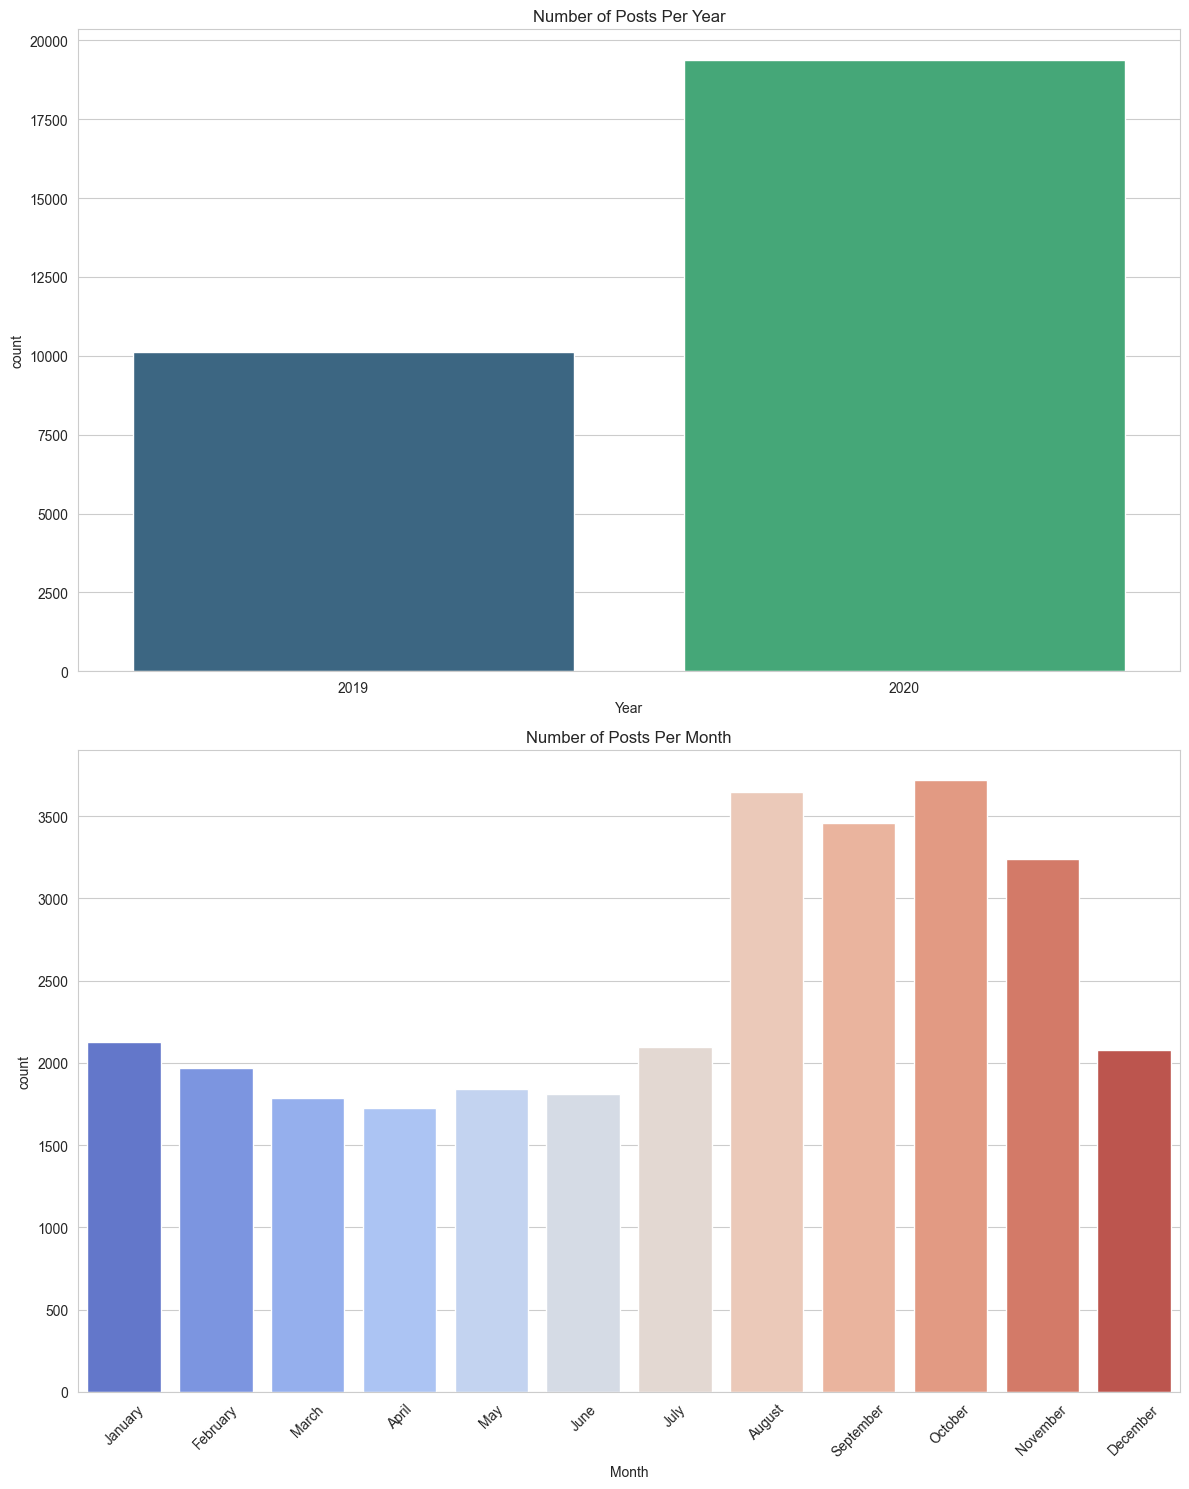

In [12]:
plt.figure(figsize=(12,15))

# Yearly post count
plt.subplot(2, 1, 1)
sns.countplot(x='Year', data=df, palette='viridis')
plt.title('Number of Posts Per Year')

# Monthly post count
plt.subplot(2, 1, 2)
sns.countplot(x='Month', data=df, order=pd.date_range("2000-01-01", periods=12, freq='M').strftime('%B'), palette='coolwarm')
plt.title('Number of Posts Per Month')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Bivariate Analysis - Word Count vs Score & Comments

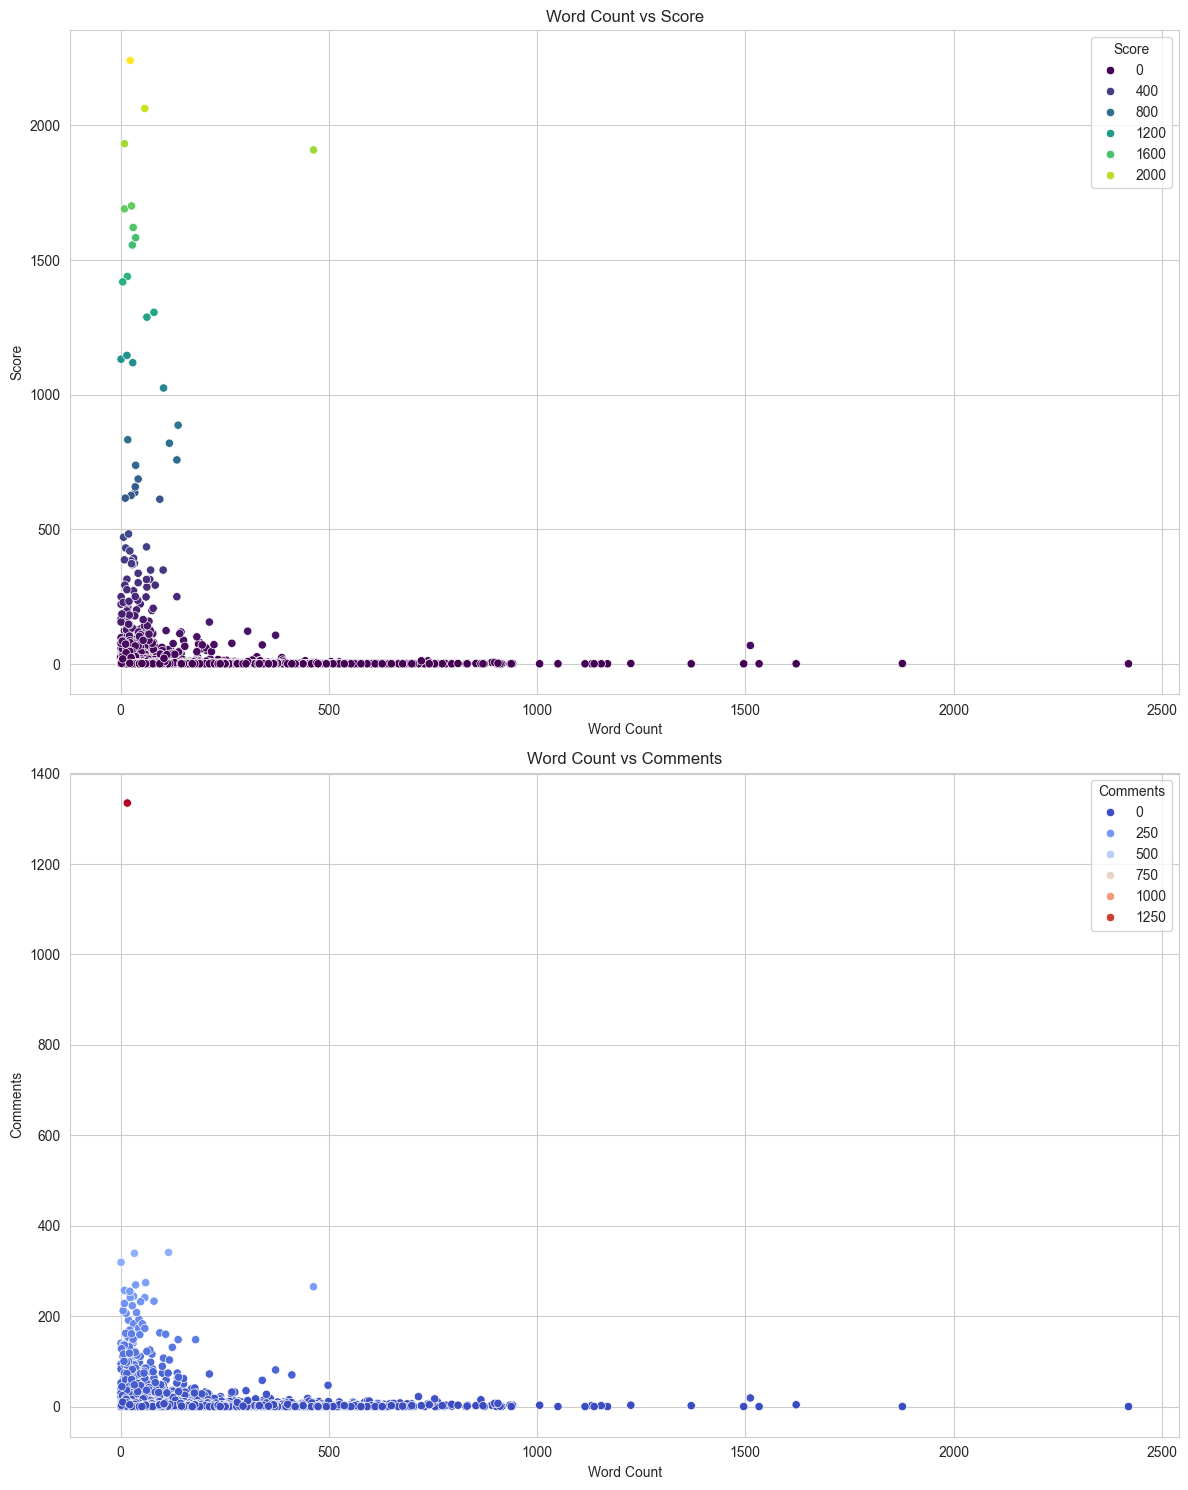

In [13]:
plt.figure(figsize=(12, 15))

# Word Count vs Score
plt.subplot(2, 1, 1)
sns.scatterplot(data=df, x='Word_Count', y='Score', hue='Score', palette='viridis')
plt.title('Word Count vs Score')
plt.xlabel('Word Count')
plt.ylabel('Score')

# Word Count vs Comments
plt.subplot(2, 1, 2)
sns.scatterplot(data=df, x='Word_Count', y='Comments', hue='Comments', palette='coolwarm')
plt.title('Word Count vs Comments')
plt.xlabel('Word Count')
plt.ylabel('Comments')

plt.tight_layout()
plt.show()

#### Emotion Analysis

In [14]:
def get_emotions(text) :
    emotion = NRCLex(text)
    return list(emotion.raw_emotion_scores.keys())

df['Emotions'] = df['Text'].apply(get_emotions)

df.head()

,Author,UTC,Year,Month,ID,Comments,Score,Text,Title,Word_Count,Emotions
0,3dgyT33N666,2020-10-13 17:22:17,2020,October,jahyyq,0.0,1.0,im fucking im tired hell sad hell emotions con...,dear,25,"[negative, anger, disgust, fear, sadness, anti..."
1,TallGhostXO,2019-12-18 01:24:12,2019,December,ec5gwf,3.0,1.0,hate fucking burning passion theres person ear...,fucking hate myself,53,"[anger, disgust, fear, negative, sadness, anti..."
2,dojacool,2020-07-26 05:16:21,2020,July,hy19hz,4.0,1.0,conversation night what do chest crushed rock ...,met year ago shes russia im manila sad want die,95,"[anger, disgust, fear, negative, sadness, posi..."
3,Klutzy_Lemon,2020-02-14 07:00:44,2020,February,f3oikf,0.0,1.0,[removed],birthday today,1,[]
4,Arandomoboy,2019-09-21 14:33:33,2019,September,d7b8ft,1.0,6.0,changed kept feels like control life strugglin...,im finally happy,24,"[disgust, fear, negative, sadness, anticipatio..."


In [15]:
# Flatten Emotion lists and Count Frequencies
emotion_list = [emotion for emotions in df['Emotions'] for emotion in emotions]
emotion_counts = Counter(emotion_list)
emotion_counts

Counter({'negative': 24161,
         'positive': 23260,
         'sadness': 23046,
         'fear': 22075,
         'trust': 21739,
         'anticipation': 21242,
         'anger': 21129,
         'joy': 19765,
         'disgust': 19399,
         'surprise': 16427})

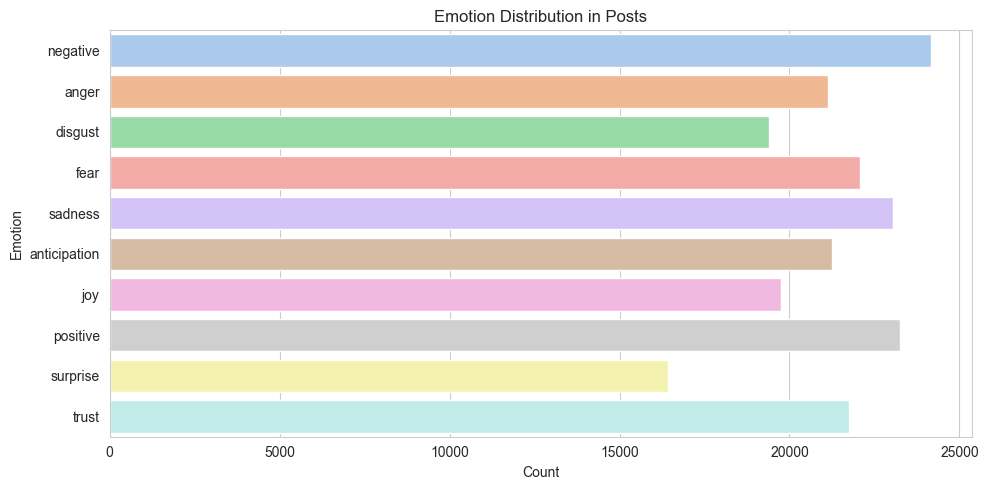

In [16]:
plt.figure(figsize=(10, 5))
sns.barplot(x=list(emotion_counts.values()), y=list(emotion_counts.keys()), palette='pastel')
plt.title('Emotion Distribution in Posts')
plt.xlabel('Count')
plt.ylabel('Emotion')
plt.tight_layout()
plt.show()

#### Most Frequent Words

In [17]:
# Convert text into a matrix of word counts
cv = CountVectorizer(stop_words='english',max_features=1000)
text_matrix = cv.fit_transform(df['Text'])

In [18]:
# Get total count for each word
word_counts = text_matrix.sum(axis=0).A1  # Convert to 1D array
words = cv.get_feature_names_out()

In [19]:
# Create a DataFrame of words and their counts
word_frequency = pd.DataFrame({'Word': words, 'Count': word_counts})

In [20]:
# Sort by count in descending order
word_frequency = word_frequency.sort_values(by='Count', ascending=False)

#### Displaying the Top 20 Words

In [21]:
print("Top 20 Words :")
print(word_frequency.head(20))

Top 20 Words :
           Word  Count
521        like  32726
462          im  32163
319        feel  28939
498        know  20667
943        want  20246
519        life  18530
885        time  14878
658      people  14432
238         don  12622
481         ive  10748
344     friends  10578
217  depression  10146
878       think   9995
372       going   9622
202         day   9568
877      things   9355
994       years   8371
930          ve   8333
422        help   8197
375        good   7301


#### Visualization of Words

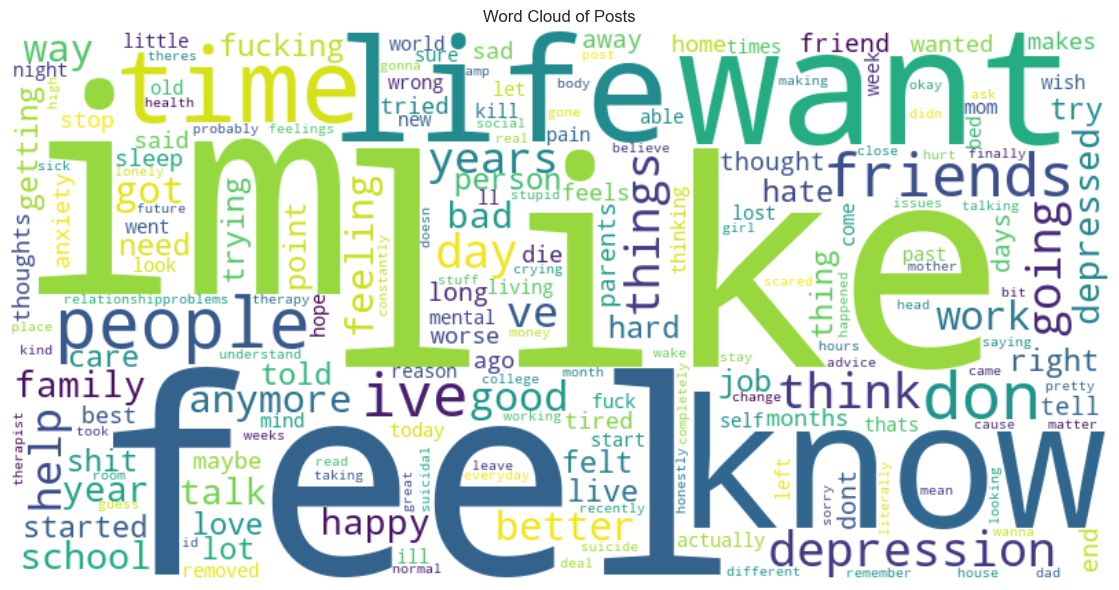

In [22]:
# Word Cloud Visualization
wordcloud = WordCloud(width=800, height=400, background_color='white') \
    .generate_from_frequencies(dict(zip(word_frequency['Word'], word_frequency['Count'])))

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Posts')
plt.tight_layout()
plt.show()

In [23]:
df.to_csv('../Dataset/Refined_Dataset.csv',index=False)